### Основное задание:  
Даны выборки для обучения и для тестирования.  Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. 
  
Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые.  Внимание! выборка assignment_2_test.csv - наш аналог лидерборда.  
  
Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. Для других целей использовать выборку запрещено!.

### Терминалогия, используемая в задании:
* обучающая выборка - выборка, которая передается в метод fit / train;
* валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (train, valid);
* тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (train, valid, test);
* ЛБ - лидерборд, выборка assignment_2_test.csv.

#### Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.  
​
#### Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.  
​
#### Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.  
 
#### Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.  
​
####  Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.  
​
#### Задание 6 (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.  
​
#####  Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).  

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import missingno as msno
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn import metrics
import seaborn as sns
from scipy.stats import probplot, ks_2samp
import warnings
from tqdm import tqdm
from typing import List, Tuple
from scipy.stats import ttest_rel
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from classes_and_functions import bootstrap_calculate_confidence_interval, make_cross_validation,make_cross_validation_gr

warnings.simplefilter("ignore")
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

In [3]:
train= pd.read_csv('train.csv')
l_board = pd.read_csv('test.csv')

In [4]:
train.set_index('TransactionID',inplace=True)
l_board.set_index('TransactionID',inplace=True)

In [5]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180000 entries, 2987000 to 3166999
Columns: 393 entries, isFraud to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 541.1+ MB


In [7]:
l_board.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100001 entries, 3287000 to 3387000
Columns: 393 entries, isFraud to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 300.6+ MB


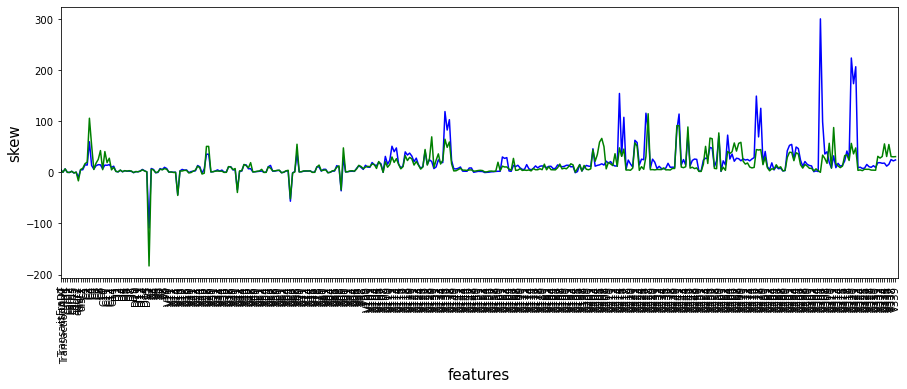

In [8]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.skew(), l_board.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

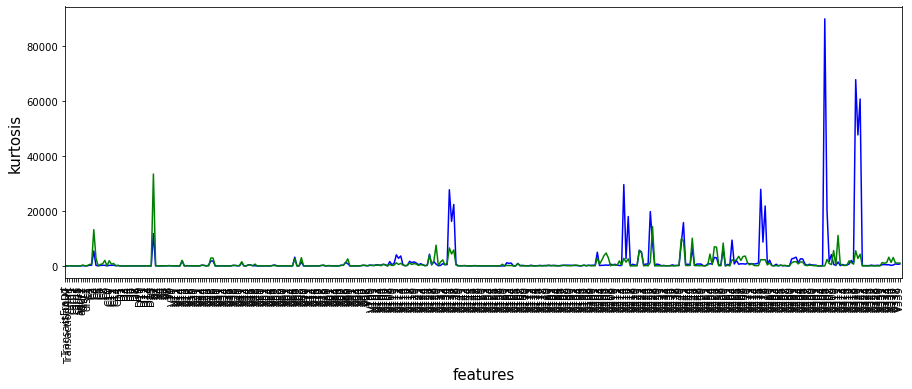

In [9]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.kurtosis(), l_board.kurtosis()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.show()

 ##### Как видно статистики на данных и ледерборде серьезно отличаются, поэтому в лоб, ожидать схожих данных на валидации и лидерюорде не приходиться

#### Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [5]:
object_features = train.select_dtypes(include=[np.object]).columns

In [13]:
train[object_features]= train[object_features].astype('category')
l_board[object_features]= l_board[object_features].astype('category')

In [8]:
x_train,x_valid,y_train,y_valid =\
train_test_split(train.drop('isFraud',axis=1),train['isFraud'], test_size = 0.2,random_state=30,stratify =train['isFraud'])

In [8]:
params_1 = {
    "boosting_type": "gbdt",
    "objective": "binary",
    'num_leaves':55,
    'max_depth':7,
    'learning_rate':0.2,
    'n_estimators':800,
    "metric": "auc",
    "n_jobs": 15,
    'reg_alpha':0.5,
    'reg_lambda':0.5,
    "random_state": 30,
    'device':"gpu"
}


In [14]:
model_1 = lgb.LGBMClassifier(**params_1)

In [15]:
%%time
model_1.fit(x_train,y_train,early_stopping_rounds  = 50,\
            eval_set =[(x_train,y_train),(x_valid,y_valid)],verbose = False)

Wall time: 20.6 s


LGBMClassifier(device='gpu', learning_rate=0.2, max_depth=7, metric='auc',
               n_estimators=800, n_jobs=15, num_leaves=55, objective='binary',
               random_state=30, reg_alpha=0.5, reg_lambda=0.5)

In [16]:
model_1.best_iteration_,model_1.best_score_

(557,
 defaultdict(collections.OrderedDict,
             {'training': OrderedDict([('auc', 0.9999999965238866)]),
              'valid_1': OrderedDict([('auc', 0.955143520041158)])}))

Качество модели на валидационной выборке 0,958  что кажется очень хорошим результатом. При  этом на трейн почти единица. 
Что говорит, что модель сильно подстроилась под данные, но при этом разность не сильно большая меньеше 5%

Оценим качество на лидер борде

In [17]:
roc_auc_score(l_board['isFraud'], model_1.predict_proba(l_board.drop('isFraud',axis=1))[:,1])

0.8411316228406028

Наблюдаем сильное отличие показателя качества на валидации и лидерборде, почти 10%  
Сказывается серьезные отличия в данныых на трйн и LB. Я думааю нужно упростить модель и увеличить регурлиризацию. Это скорее всего уменьшит скор валидации, но может привезти к росту качетсва на LB

In [7]:
params_2 = {
    "boosting_type": "gbdt",
    "objective": "binary",
    'num_leaves':45,
    'max_depth':4,
    'learning_rate':0.1,
    'n_estimators':250,
    "metric": "auc",
    "n_jobs": 15,
    'reg_alpha':2,
    'reg_lambda':2,
    "random_state": 30,
    'device':"gpu"
}

In [19]:
model_2 = lgb.LGBMClassifier(**params_2)

In [20]:
%%time
model_2.fit(x_train,y_train,early_stopping_rounds  = 50,\
            eval_set =[(x_train,y_train),(x_valid,y_valid)],verbose = False)

Wall time: 5.91 s


LGBMClassifier(device='gpu', max_depth=4, metric='auc', n_estimators=250,
               n_jobs=15, num_leaves=45, objective='binary', random_state=30,
               reg_alpha=2, reg_lambda=2)

In [21]:
model_2.best_iteration_,\
model_2.best_score_,roc_auc_score(l_board['isFraud'],\
            model_2.predict_proba(l_board.drop('isFraud',axis=1))[:,1])


(250,
 defaultdict(collections.OrderedDict,
             {'training': OrderedDict([('auc', 0.9499340651688626)]),
              'valid_1': OrderedDict([('auc', 0.9214691653267028)])}),
 0.865096111426706)

Как  видно упростив модель, скор на валилдации заметно упал, но зато немного прибавил скор на лидер борде. Но все равно разность большая

#### Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [22]:
x_train,x_valid,y_train,y_valid = \
train_test_split(train.drop('isFraud',axis=1),train['isFraud'], test_size = 0.3,random_state=30,stratify =train['isFraud'])

In [23]:
x_valid,x_test,y_valid,y_test = \
    train_test_split(x_valid,y_valid, test_size = 0.5 ,random_state=30,stratify =y_valid)

In [24]:
x_valid.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27000 entries, 3087188 to 3115977
Columns: 392 entries, TransactionDT to V339
dtypes: category(14), float64(376), int64(2)
memory usage: 78.4 MB


In [25]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27000 entries, 3027424 to 2992991
Columns: 392 entries, TransactionDT to V339
dtypes: category(14), float64(376), int64(2)
memory usage: 78.4 MB


In [26]:
model_1 = lgb.LGBMClassifier(**params_1)

In [27]:
%%time
model_1.fit(x_train,y_train,early_stopping_rounds  = 50,\
            eval_set =[(x_train,y_train),(x_valid,y_valid)],verbose = False)

Wall time: 11.6 s


LGBMClassifier(device='gpu', learning_rate=0.2, max_depth=7, metric='auc',
               n_estimators=800, n_jobs=15, num_leaves=55, objective='binary',
               random_state=30, reg_alpha=0.5, reg_lambda=0.5)

In [28]:
print(f'лучшая итерация {model_1.best_iteration_}')
print(f"Лучший скор трайн {model_1.best_score_['training']['auc']} на валидации  {model_1.best_score_['valid_1']['auc']}")
print(f'Cкор на отложенной выборке {roc_auc_score(y_test, model_1.predict_proba(x_test)[:,1])}')
print(f"Cкор на либерборде {roc_auc_score(l_board['isFraud'], model_1.predict_proba(l_board.drop('isFraud',axis=1))[:,1])}")

лучшая итерация 312
Лучший скор трайн 0.9998021934013668 на валидации  0.9490083327238654
Cкор на отложенной выборке 0.9579443926953064
Cкор на либерборде 0.8427258009591625


Как видно скор на отложенной выборке почти такой же как и на валидации, что говорит о тоом, что на обучающей выбоке схожие данные. Но лидер борде, опять имеем очень сильный отрыв .  
Опять попробуем упростить модель

In [29]:
model_2 = lgb.LGBMClassifier(**params_2)

In [30]:
%%time
model_2.fit(x_train,y_train,early_stopping_rounds  = 50,\
            eval_set =[(x_train,y_train),(x_valid,y_valid)],verbose = False)

Wall time: 5.38 s


LGBMClassifier(device='gpu', max_depth=4, metric='auc', n_estimators=250,
               n_jobs=15, num_leaves=45, objective='binary', random_state=30,
               reg_alpha=2, reg_lambda=2)

In [31]:
print(f'лучшая итерация {model_2.best_iteration_}')
print(f"Лучший скор трайн {model_2.best_score_['training']['auc']} на валидации  {model_2.best_score_['valid_1']['auc']}")
print(f'Cкор на отложенной выборке {roc_auc_score(y_test, model_2.predict_proba(x_test)[:,1])}')
print(f"Cкор на либерборде {roc_auc_score(l_board['isFraud'], model_2.predict_proba(l_board.drop('isFraud',axis=1))[:,1])}")

лучшая итерация 250
Лучший скор трайн 0.9523132200046518 на валидации  0.9206329426458837
Cкор на отложенной выборке 0.926264969730092
Cкор на либерборде 0.8625098265152018


Как видно показатель качества не сильно отличается на валидационной и на тестовой выборке и их сильно преврсходит лидерборд. То есть модель на своих данных стабильна. Но как только появляются данне м ЛБ, все идет не так. Таким образом,  модель на ЛБ будет работать по доугому, видимо данные сильно отличаются

### Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [32]:
# доверительный интервал на данных из п.2 на основе бутстреп выборок
np.random.seed(1)
bootstrap_calculate_confidence_interval(y_test,model_2.predict_proba(x_test)[:,1], roc_auc_score)


(0.914454705239818, 0.9376253936288247)

In [33]:
# Скор на лидерборде
roc_auc_score(l_board['isFraud'], model_2.predict_proba(l_board.drop('isFraud',axis=1))[:,1])

0.8625098265152018

Данные на лидерборде не попадают в доверительный интервал

 Видимо данные сильно отличаются в моделе и лидерборде.

### Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

Пробовал на полнойм трейне весь результат лежит до 0,1 , дмного вариантов пробовал, такой подход дал результат по лучше  
Поэтому  
Возмем из трейна , для обучения Adversarial Validation случайные 100 000 , а на остальных 80 000 будем отбирать выборку для валидации

Так же обязательно нужно убрать TransactionDT, так как по нему модель чекто понимает из какой выборки данные

In [9]:
n = 80000
x_adv_tr,x_adv_test = train_test_split(train.drop(['isFraud','TransactionDT'],axis=1), \
                                test_size = n,random_state=31,stratify =train['isFraud'],shuffle = True)

In [10]:
x_adv_tr.shape, x_adv_test.shape

((100000, 391), (80000, 391))

In [11]:
x_adv = pd.concat([
    x_adv_tr, l_board.drop(['isFraud','TransactionDT'],axis=1)], axis=0
)
y_adv = np.hstack((np.zeros(x_adv_tr.shape[0]), np.ones(l_board.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [16]:
x_adv[object_features]= x_adv[object_features].astype('category')

Поскольку признаки сильно разные, необходимо  сильно упростить и ослабить модель, что бы она могла не переобучилась на тренировочной выборке

In [20]:
%%time
model_adv = lgb.LGBMClassifier()
model_adv.fit(x_adv,y_adv,verbose = False )


Wall time: 4.9 s


LGBMClassifier()

In [21]:
roc_auc_score(y_adv, model_adv.predict_proba(x_adv)[:,1])

0.9195630957190428

Как видно 'auc' очень высокий

In [22]:

pred = model_adv.predict_proba(x_adv_test)[:,1]

In [23]:
pd.cut(
    pred, bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    15753
(0.1, 0.2]    22487
(0.2, 0.3]    18201
(0.3, 0.4]     8261
(0.4, 0.5]     6625
(0.5, 0.6]     3275
(0.6, 0.7]     2571
(0.7, 0.8]     2492
(0.8, 0.9]      241
(0.9, 1.0]       94
dtype: int64

Возмем на валидацию, все что больше или равно 0,3

In [24]:
# индексы, где значение вероятности более 0,3
ind_val = np.where(pred>0.35)[0]

In [25]:
len(ind_val)

18674

Получилось 18674 строк для валидации - это не плохо. Посмотрим как распределен таргет в этой выборке и сравним его с общим

In [26]:
# Общий таргет
a = train['isFraud'].value_counts(normalize = True)
a

0    0.971439
1    0.028561
Name: isFraud, dtype: float64

In [27]:
# Таргет в нашей выборке
b = train.iloc[ind_val]['isFraud'].value_counts(normalize = True)
b

0    0.973653
1    0.026347
Name: isFraud, dtype: float64

Как видно есть различия. Уберем немного нулевых значений, что бы сравнять распределение

In [28]:
print(f'общий объем выборки {len(ind_val)}')
for_del = int(len(ind_val)*b[0] - len(ind_val)*a[0])
print(f'убрать -  {for_del}')
count = len(ind_val) - for_del
print(f'остается {count}')

общий объем выборки 18674
убрать -  41
остается 18633


In [29]:
k=0
while k<for_del:
    ind =  np.random.choice(ind_val)
    if train.iloc[ind]['isFraud']==0:
        index = np.argwhere(ind_val==ind)
        ind_val = np.delete(ind_val,index)
        k+=1

In [30]:
len(ind_val)

18633

In [31]:
train.iloc[ind_val]['isFraud'].value_counts(normalize = True)

0    0.973595
1    0.026405
Name: isFraud, dtype: float64

In [32]:
X_test = train.iloc[ind_val]

In [33]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18633 entries, 2987005 to 3066998
Columns: 393 entries, isFraud to V339
dtypes: category(14), float64(376), int64(3)
memory usage: 54.3 MB


In [34]:
X_train= train.drop(X_test.index)

In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161367 entries, 2987000 to 3166999
Columns: 393 entries, isFraud to V339
dtypes: category(14), float64(376), int64(3)
memory usage: 470.0 MB


In [36]:
y_train=X_train['isFraud']
y_test=X_test['isFraud']
X_train=X_train.drop('isFraud',axis=1)
X_test=X_test.drop('isFraud',axis=1)


In [37]:
model_3 = lgb.LGBMClassifier()

In [38]:
%%time
model_3.fit(X_train,y_train,verbose = False)


Wall time: 4.25 s


LGBMClassifier()

In [39]:
# Скор на валидации и лидерборде

roc_auc_score(l_board['isFraud'], model_3.predict_proba(l_board.drop('isFraud',axis=1))[:,1]),\
roc_auc_score(y_test, model_3.predict_proba(X_test)[:,1])

(0.8664550705058922, 0.9297316683271016)

В общем два дня крутил, не получается приблизить скор валидационной выборки к тестовой

### Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы

In [1274]:
# создадим отложенную выборку
x_train,x_test,y_train,y_test = \
    train_test_split(train.drop('isFraud',axis=1),train['isFraud'], test_size = 0.2,random_state=1)

In [1275]:
model=lgb.LGBMClassifier(**params_1)

In [1280]:
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=1)

In [1281]:
cv =  make_cross_validation(x_train,
                          y_train,
                          model,
                          roc_auc_score,
                          cv_strategy)

Fold: 1, train-observations = 129600, valid-observations = 14400
train-score = 1.0, valid-score = 0.9556
Fold: 2, train-observations = 129600, valid-observations = 14400
train-score = 1.0, valid-score = 0.9545
Fold: 3, train-observations = 129600, valid-observations = 14400
train-score = 1.0, valid-score = 0.9553
Fold: 4, train-observations = 129600, valid-observations = 14400
train-score = 0.9974, valid-score = 0.9615
Fold: 5, train-observations = 129600, valid-observations = 14400
train-score = 0.9998, valid-score = 0.9612
Fold: 6, train-observations = 129600, valid-observations = 14400
train-score = 1.0, valid-score = 0.9542
Fold: 7, train-observations = 129600, valid-observations = 14400
train-score = 0.9996, valid-score = 0.9577
Fold: 8, train-observations = 129600, valid-observations = 14400
train-score = 0.9998, valid-score = 0.9663
Fold: 9, train-observations = 129600, valid-observations = 14400
train-score = 1.0, valid-score = 0.956
Fold: 10, train-observations = 129600, valid

In [1282]:
max(cv[3]),min(cv[3])

(0.9662971693203914, 0.9542470380490544)

Как видно даже при 10 сплитах валидация на обучающей выборке стабильна.

In [1283]:
# Скор на отложенной выборке
model.fit(x_train,y_train)
roc_auc_score(y_test, model.predict_proba(x_test)[:,1])

0.9560178745315245

Результат на отлоденной выборке так же говорит о том, что валидация на тренировочных данныхз стабильна

In [1284]:
# Скор на лидерборде
roc_auc_score(l_board['isFraud'], model.predict_proba(l_board.drop('isFraud',axis=1))[:,1])

0.8497950752720054

Однако традиционно имеем совршенно иной результат на лидерборде

### Задание 6 (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.

In [1286]:
data = train.sort_values(by='TransactionDT')
data.shape

(180000, 393)

In [1287]:
x_train = data.drop('isFraud',axis=1).iloc[:150000]
x_valid = data.drop('isFraud',axis=1).iloc[150000:]
y_train = data['isFraud'].iloc[:150000]
y_valid = data['isFraud'].iloc[150000:]

In [1288]:
x_train.shape ,x_valid.shape ,y_train.shape ,y_valid.shape 

((150000, 392), (30000, 392), (150000,), (30000,))

In [1289]:
x_test = x_valid.iloc[:20000]
x_valid = x_valid.iloc[20000:]
y_test = y_valid.iloc[:20000]
y_valid = y_valid.iloc[20000:]


In [1290]:
x_test.shape ,x_valid.shape ,y_test.shape ,y_valid.shape 

((20000, 392), (10000, 392), (20000,), (10000,))

In [1291]:
dtrain = lgb.Dataset(data=x_train, label=y_train,categorical_feature=object_features.to_list())
dvalid = lgb.Dataset(data=x_valid, label=y_valid,categorical_feature=object_features.to_list())

In [1292]:
params_t = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "n_jobs": 15,
    "seed": 5
}

In [1293]:
model_t = lgb.train(
    params=params_t,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature=object_features.to_list(),
    early_stopping_rounds=90,
    verbose_eval=None
)

[LightGBM] [Info] Number of positive: 3970, number of negative: 146030
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31874
[LightGBM] [Info] Number of data points in the train set: 150000, number of used features: 390
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026467 -> initscore=-3.605046
[LightGBM] [Info] Start training from score -3.605046


In [1294]:
model_t.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('auc', 0.9806719488128367)]),
             'valid_1': OrderedDict([('auc', 0.9302275318103045)])})

In [1295]:
roc_auc_score(y_test, model_t.predict(x_test))

0.9227191579683471

In [1297]:
roc_auc_score(l_board['isFraud'], model_t.predict(l_board.drop('isFraud',axis=1)))

0.8713025757026576

In [1300]:
# доверительный интервал на данных из п.2 на основе бутстреп выборок
np.random.seed(1)
bootstrap_calculate_confidence_interval(y_test,model_t.predict(x_test), roc_auc_score)

(0.9120344036371724, 0.9336053222419792)

Мимо!

### Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

In [41]:
def conc_client(x):
    z = ''
    for i in x[object_features]:
        z += " " +str(i)
    return z    
        

In [42]:
a = pd.concat([train,l_board],axis=0)

In [43]:
a['client'] = a.apply(conc_client , axis = 1)

In [44]:
a['client'] = a['client'].map(a['client'].value_counts())

In [45]:
train = a.iloc[:train.shape[0]]
l_board = a.iloc[train.shape[0]:]

In [46]:
train[object_features]=train[object_features].astype('category')
l_board[object_features]=l_board[object_features].astype('category')

In [47]:
group_kfold = GroupKFold(n_splits=5)
X = train.drop(['isFraud'],axis=1)
y = train['isFraud']
groups = train['client']
cv_strategy = group_kfold

In [48]:
model=lgb.LGBMClassifier()

In [49]:
cv =  make_cross_validation_gr(X,
                          y,
                          model,
                          roc_auc_score,
                          cv_strategy,groups)

Fold: 1, train-observations = 144014, valid-observations = 35986
train-score = 0.9771, valid-score = 0.9216
Fold: 2, train-observations = 143998, valid-observations = 36002
train-score = 0.9746, valid-score = 0.9074
Fold: 3, train-observations = 143986, valid-observations = 36014
train-score = 0.9737, valid-score = 0.9246
Fold: 4, train-observations = 143991, valid-observations = 36009
train-score = 0.9776, valid-score = 0.8783
Fold: 5, train-observations = 144011, valid-observations = 35989
train-score = 0.9743, valid-score = 0.9188
CV-results train: 0.9755 +/- 0.002
CV-results valid: 0.9101 +/- 0.017
OOF-score = 0.9129


In [50]:
max(cv[3]),min(cv[3])

(0.9245989654058079, 0.8783245982837067)

In [51]:
model.fit(X,y)

LGBMClassifier()

In [52]:
roc_auc_score(l_board['isFraud'], model.predict(l_board.drop('isFraud',axis=1)))

0.6499901998557179

Мимо